In [117]:
import pandas as pd
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

In [118]:
X_raw = pd.read_csv(r'S:\Columbia MS DS\Courses\Semester_02\03 - COMS_4721 - ML for DS\HW 2\hw2-data\Bayes_classifier\X.csv'
                          ,header=None
                          ,names=[i for i in range(1,55)]
                        )
Y_raw = pd.read_csv(r'S:\Columbia MS DS\Courses\Semester_02\03 - COMS_4721 - ML for DS\HW 2\hw2-data\Bayes_classifier\Y.csv'
                          ,header=None
                          ,names=['spam']
                        )

In [245]:
X_raw.head(3)
#Y_raw.head(3)

,1,2,3,4,5,6,7,8,9,10,...,45,46,47,48,49,50,51,52,53,54
0,0,6,6,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,8,0,0
1,2,3,5,0,1,3,2,1,0,9,...,0,0,0,0,0,1,0,4,2,0
2,1,0,7,0,12,2,2,1,6,3,...,1,1,0,0,0,1,0,3,2,0


## Naive Bayes

In [119]:
def MLE_finder(dfX, dfY):
    pi_hat = dfY.sum()/dfY.shape[0]
    total_notspam = (dfY.shape[0] - dfY.sum()).item()
    total_spam = dfY.sum().item()
    
    #print(pi_hat)
    #print(f'not spam:{(total_notspam)}')
    
    lambda_hat_0d_arr = (dfX.where(dfY.spam==0).sum()+1)/(total_notspam + 1)  #including 1 for gamma prior
    lambda_hat_1d_arr = (dfX.where(dfY.spam==1).sum()+1)/(total_spam + 1)
    
    return pi_hat, lambda_hat_0d_arr, lambda_hat_1d_arr

In [120]:
#predict funciton takes MLEs and finds which is more likely
def predict_from_MLE(dfXSeries, p, l0, l1):
    probY0 = 1.0
    probY1 = 1.0
    LNprobY0 = 0
    LNprobY1 = 0
    for d in range(1,dfXSeries.shape[0]+1):
        k = dfXSeries[d].item()
        probY0 = probY0 * poisson.pmf(k, l0[d])
        probY1 = probY1 * poisson.pmf(k, l1[d])
        #LNprobY0 = LNprobY0 + np.log(poisson.pmf(k, l0[d]))
        #LNprobY1 = LNprobY1 + np.log(poisson.pmf(k, l1[d]))
        #print(f'K:{k} -- LNProb0:{LNprobY0:0.3} -- LNProb0:{LNprobY1:0.3}')
        
    probY0 = (1-p)*probY0
    probY1 = (p)*probY1
    #LNprobY0 = np.log(1-p) + LNprobY0
    #LNprobY1 = np.log(p) + LNprobY1

    #print(probY0)
    #print(probY1)
    #print(LNprobY0)
    #print(LNprobY1)
    if probY0.item() >= probY1.item():
    #if LNprobY0.item() >= LNprobY1.item():
        return 0
    else:
        return 1

In [160]:
#split data
permuted_indices = np.random.permutation(len(X_raw))
#print(permuted_indices)

X_folds = []
Y_folds = []
for i in range(10):
    X_folds.append(X_raw.iloc[permuted_indices[i::10]])
    Y_folds.append(Y_raw.iloc[permuted_indices[i::10]])
#dfs[0].shape
#Y_folds

In [180]:
%%time
T_That = 0
T_Fhat = 0
F_That = 0
F_Fhat = 0
lambda0_params = []
lambda1_params = []

for h in range(0,10):
    #reconstruct data from randomized split
    heldout = h
    X_train = pd.concat([X_folds[i] for i in range(0,10) if i != heldout])
    y_train = pd.concat([Y_folds[i] for i in range(0,10) if i != heldout])
    X_test = pd.concat([X_folds[heldout]])
    y_test = pd.concat([Y_folds[heldout]])

    #get parameters
    pi, lambda_0d_arr, lambda_1d_arr = MLE_finder(X_train,y_train)
    lambda0_params.append(lambda_0d_arr)
    lambda1_params.append(lambda_1d_arr)

    #predict on test
    for x in range(0,X_test.shape[0]):
        y_hat = predict_from_MLE(X_test.iloc[x,:], pi, lambda_0d_arr, lambda_1d_arr)
        y_true = y_test.iloc[x].item()
        #print(f'True Y:{y_true} ----  Predict Y:{y_hat}')
        if(y_true == y_hat and y_true == 1):
            T_That += 1
        elif(y_true == y_hat and y_true == 0):
            F_Fhat += 1
        elif(y_true != y_hat and y_true == 1):
            T_Fhat += 1
        elif(y_true != y_hat and y_true == 0):
            F_That += 1

#print aggregate summary
print('      True                          False         ')
print(f' True Positive: {T_That} --- False Positive: {F_That}') #predicted true
print(f'False Negative: {T_Fhat} ---  True Negative: {F_Fhat}') #predicted false
print(f'Prediction Accuracy: {(T_That+F_Fhat)/(T_That+F_That+T_Fhat+F_Fhat):0.3}')

      True                          False         
 True Positive: 1704 --- False Positive: 491
False Negative: 109 ---  True Negative: 2296
Prediction Accuracy: 0.87
CPU times: total: 39.6 s
Wall time: 45.8 s


C:\Users\Devan\AppData\Local\Temp\ipykernel_15176\2879199318.py:3: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  markerline1, stemlines, _ = plt.stem(x1, pd.DataFrame(lambda0_params).mean(), '-.')
C:\Users\Devan\AppData\Local\Temp\ipykernel_15176\2879199318.py:5: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  markerline2, stemlines, _ = plt.stem(x1, pd.DataFrame(lambda1_params).mean() , '-.')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


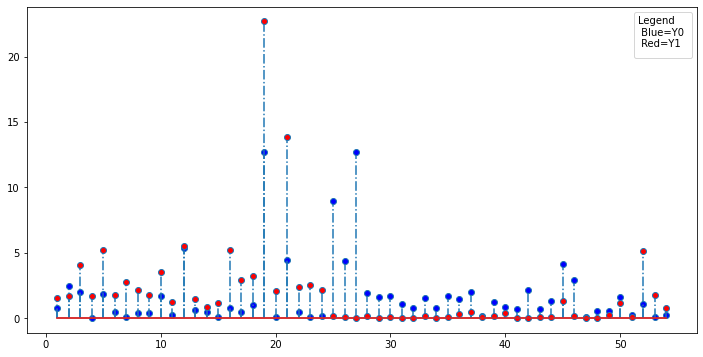

In [192]:
x1 = list(range(1, 55))
figure, axis = plt.subplots(1, 1, figsize=(12,6))
markerline1, stemlines, _ = plt.stem(x1, pd.DataFrame(lambda0_params).mean(), '-.')
plt.setp(markerline1, 'markerfacecolor', 'b')
markerline2, stemlines, _ = plt.stem(x1, pd.DataFrame(lambda1_params).mean() , '-.')
plt.setp(markerline2, 'markerfacecolor', 'r')
plt.legend(title='Legend \n Blue=Y0 \n Red=Y1')
plt.show()

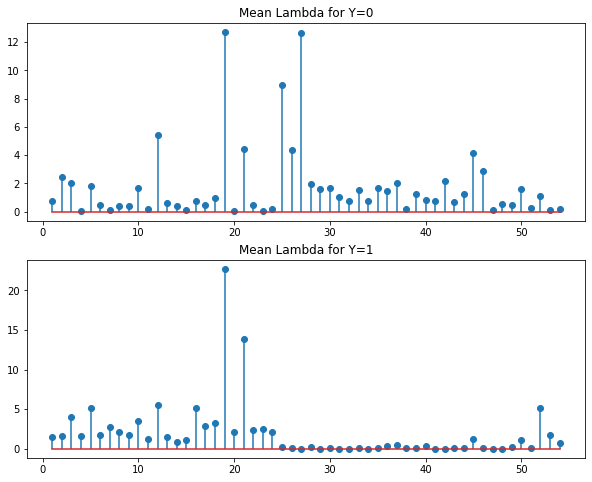

In [181]:
figure, axis = plt.subplots(2, 1, figsize=(10,8))
axis[0].stem( range(1,55), pd.DataFrame(lambda0_params).mean() )
axis[0].set_title("Mean Lambda for Y=0")
axis[1].stem( range(1,55), pd.DataFrame(lambda1_params).mean() )
axis[1].set_title("Mean Lambda for Y=1");